# PART B

## Set-Up and Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
import seaborn as sbs
from ast import literal_eval
import datetime as dt

In [2]:
# adding literal_eval conversion to the concatenated column to read as list
ab_data = pd.read_csv("data/dataset.tsv", sep = '\t', converters = {'popup_version|start_date|popup_category': literal_eval})

In [2]:
## Alternative approach to splitting without literal eval
# ab_data_1 = pd.read_csv("data/dataset.tsv", sep = '\t')
# ab_data_1["popup_version|start_date|popup_category"] = \
# ab_data_1["popup_version|start_date|popup_category"].apply(lambda x:x[2:-2].split('","'))
# ab_data_1[["popup_version", "start_date" , "popup_category"]] = \
# pd.DataFrame(ab_data_1["popup_version|start_date|popup_category"].tolist(), index = ab_data_1.index)

## Data sense-checks

In [4]:
# rows/cols
ab_data.shape

(2063, 9)

In [5]:
# null check
ab_data.isnull().sum().sum()

0

In [6]:
# Dup check:
ab_data[ab_data.loc[:, ab_data.columns != "popup_version|start_date|popup_category"].duplicated(keep = False)].shape

(8, 9)

## Split concatenated column

In [7]:
# Split column:
ab_data[["popup_version", "start_date" , "popup_category"]] = \
pd.DataFrame(ab_data["popup_version|start_date|popup_category"].tolist(), index = ab_data.index)

#check shape
ab_data.shape

(2063, 12)

## Question 3

In [8]:
# Filter onto rows running a/b experiments with valid start dates
valid_ab_data = ab_data.loc[(ab_data.popup_version != "") & (ab_data.start_date != "")].copy()

In [9]:
# count unique popup versions per popup name
valid_ab_data.groupby('popup_name', as_index = False).agg({'popup_version':'nunique'}).\
sort_values('popup_version', ascending = False)

,popup_name,popup_version
0,Author Bio Template 2 (New Style),2
73,Freelance Report 1,2
84,Learning Dialogue,2
148,Marketplace Marketing Echo,2
149,Marketplace Marketing Foxtrot,2
...,...,...
82,Learning Cookbook,1
83,Learning Design,1
86,Learning Growing Influence,1
87,Learning International Pricing,1


In [10]:
# count unique dates per popup name
valid_ab_data.groupby('popup_name', as_index = False).agg({'start_date':'nunique'}).\
sort_values('start_date', ascending = False)

,popup_name,start_date
4,Book Launch Checklist 4 (New Style),13
188,bookly Book Editor Foxtrot,13
25,Default – Discovery,12
150,Marketplace Professionals Alpha,12
3,Book Launch Checklist 3,11
...,...,...
118,Learning | Reviews | 2020-03,1
117,Learning | Query Letters | 2020-04,1
115,Learning | POV | 2020-05,1
49,Discovery - Historical Romance 1,1


In [11]:
# Multiple start dates per popup name suggest that multiple experiments were ran on some popup names
# Each unique combination of popup_name and start_date should identify each distinct experiment.
valid_ab_data["popup_name_dt"] = valid_ab_data.popup_name + ' _' + valid_ab_data.start_date

In [12]:
# Here we'll discount any experiments that don't have results for both popup verions, as they are incomplete.
completed_ab_exps = valid_ab_data.groupby('popup_name_dt', as_index = False).agg({'popup_version':'nunique'})
completed_ab_exps = completed_ab_exps.rename({'popup_version':'popup_versions'}, axis = 1)
completed_ab_exps = completed_ab_exps.loc[completed_ab_exps.popup_versions == 2].copy()

In [13]:
# df of completed a/b experiments
completed_ab_data = valid_ab_data.merge(completed_ab_exps, how = 'inner', on = 'popup_name_dt')

In [14]:
# Calculate conversion rate for each experiment

# sum views and registrations
summary_df = completed_ab_data.groupby(['popup_name', 'start_date', 'popup_version'], as_index = False).\
agg({'views':sum, 'registrations':sum})

# calculate conversion rate
summary_df["conversion_rate"] = summary_df.registrations / summary_df.views

In [15]:
# Rank the popup versions by conversion rate
summary_df["c_rank"] = summary_df.groupby(['popup_name', 'start_date']).\
conversion_rate.rank(ascending = False, method = 'min').astype('int')

# Filter onto most performant popup versions
summary_final_df = summary_df.loc[summary_df.c_rank == 1].copy()

# Drop the rank column to display
summary_final_df = summary_final_df.drop('c_rank', axis = 1).copy()

In [16]:
# Display
summary_final_df.style.format({
    "views": "{:,}",
    "registrations": "{:,}",
    "conversion_rate": "{:.2%}"
}).hide(axis="index")

popup_name,start_date,popup_version,views,registrations,conversion_rate
Book Launch Checklist 4 (New Style),2020-02-27,B,"1,078",35,3.25%
Book Launch Checklist 4 (New Style),2020-05-05,B,"3,549",63,1.78%
Book Launch Checklist 4 (New Style),2020-05-06,A,882,21,2.38%
Book Marketing Checklist 3 (New Style),2020-05-27,A,742,70,9.43%
Book Marketing Checklist 3 (New Style),2020-06-12,A,21,0,0.00%
Book Marketing Checklist 3 (New Style),2020-06-12,B,924,0,0.00%
Book Proposal Template 1,2019-04-16,A,70,0,0.00%
Book Proposal Template 1,2019-04-16,B,21,0,0.00%
Character Profile Checklist 3,2020-05-01,A,"2,296",35,1.52%
Character Profile Checklist 4,2020-05-01,A,"4,529",126,2.78%


## Question 4

In [34]:
# Calculate conversion rates by start date

# Here we'll use rows running a/b experiments that have valid start dates
# valid_ab_data.head(1)

In [19]:
# Group by start date and aggregate
# sum views and registrations
start_date_summary = valid_ab_data.groupby('start_date', as_index = False).agg({'views':sum, 'registrations':sum})

# calculate conversion rate
start_date_summary["conversion_rate"] = start_date_summary.registrations / start_date_summary.views

In [20]:
# Display
start_date_summary.style.format({
    "views": "{:,}",
    "registrations": "{:,}",
    "conversion_rate": "{:.2%}"
}).hide(axis="index")

start_date,views,registrations,conversion_rate
2018-06-28 00:00:00,"7,462",56,0.75%
2018-11-14 00:00:00,35,0,0.00%
2018-12-31 00:00:00,21,0,0.00%
2019-01-22 00:00:00,637,112,17.58%
2019-03-19 00:00:00,35,0,0.00%
2019-03-20 00:00:00,"3,626",0,0.00%
2019-04-03 00:00:00,210,0,0.00%
2019-04-11 00:00:00,112,21,18.75%
2019-04-12 00:00:00,147,21,14.29%
2019-04-13 00:00:00,56,0,0.00%


In [32]:
# Plotting by day will be too granular, so we'll add month and Qtr columns
valid_ab_data["start_date"] = pd.to_datetime(valid_ab_data.start_date)
valid_ab_data["month"] = valid_ab_data.start_date.dt.to_period('m')
valid_ab_data["quarter"] = valid_ab_data.start_date.dt.to_period('Q')

In [21]:
# Group by quarter and aggregate
# sum views and registrations
qt_summary = valid_ab_data.groupby('quarter', as_index = False).agg({'views':sum, 'registrations':sum})

# calculate conversion rate
qt_summary["conversion_rate"] = qt_summary.registrations / qt_summary.views

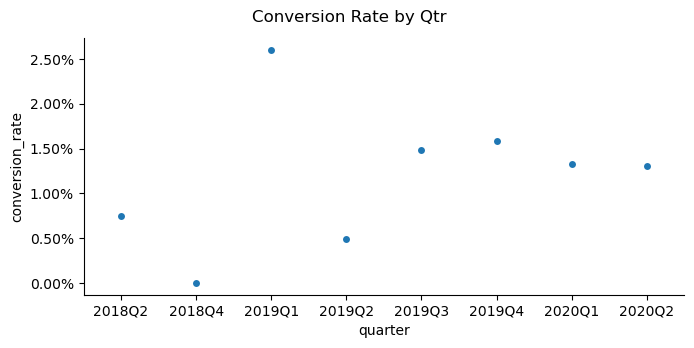

In [54]:
# Plot
p = sbs.catplot(data = qt_summary,  x = 'quarter', y = 'conversion_rate', aspect = 2, height = 3.5)
for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle('Conversion Rate by Qtr')
plt.show()